# Baseline Fast-Charging Protocols Evaluation

This notebook evaluates standard baseline charging protocols to establish performance benchmarks for comparison against multi-objective Bayesian optimization results.

---

## Baselines Tested:

1. **CCCV (2C)** - Industry standard: Constant current at 2C
2. **Linear Taper (3C→1C)** - Tesla-style: Linear decrease from 3C to 1C
3. **Linear Taper (3C→0.5C)** - Aggressive taper: 3C to 0.5C
4. **BO Aggressive (3-0-3C)** - Best from single-objective BO (β=0.008)
5. **BO Conservative (0.91-0-0.54C)** - Low degradation from single-objective BO (β=0.015)

---

## Configuration:

- **Cell**: LG M50 (NMC-graphite, OKane2022 parameters)
- **Degradation modes**: Lithium plating + SEI growth
- **SOC range**: 10-90% (realistic user scenario)
- **Time window**: 30 minutes
- **Thermal**: Isothermal (no thermal model)

---

## 1. Setup and Imports

In [1]:
# Add parent directory to path
import sys
sys.path.insert(0, '..')

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Our modules
from utils.pybamm_simulator import PyBaMMSimulator
from utils.baseline_protocols import (
    get_all_baselines,
    protocol_to_string,
    validate_protocol,
    STANDARD_BASELINES
)

print("✓ Imports successful")

✓ Imports successful


## 2. Initialize Simulator

Configure PyBaMM simulator with:
- Reversible lithium plating
- SEI growth (ec reaction limited)
- 10-90% SOC range

In [2]:
# Initialize simulator with plating + SEI
simulator = PyBaMMSimulator(
    degradation_modes=['plating', 'SEI'],
    soc_start=0.1,  # 10% SOC
    soc_end=0.9,    # 90% SOC
    charge_time_minutes=30.0
)

print(f"Simulator initialized:")
print(f"  Degradation modes: {simulator.degradation_modes}")
print(f"  SOC range: {simulator.soc_start*100:.0f}% - {simulator.soc_end*100:.0f}%")
print(f"  Time window: {simulator.charge_time_minutes} minutes")

Simulator initialized:
  Degradation modes: ['plating', 'SEI']
  SOC range: 10% - 90%
  Time window: 30.0 minutes


## 3. Load and Validate Baseline Protocols

In [3]:
# Get all baseline protocols
baselines = get_all_baselines(time_minutes=30.0)

print(f"Loaded {len(baselines)} baseline protocols:\n")

for i, protocol in enumerate(baselines, 1):
    # Validate protocol
    is_valid, msg = validate_protocol(protocol)
    status = "✓" if is_valid else "✗"
    
    print(f"{i}. {status} {protocol_to_string(protocol)}")
    print(f"   {protocol['description']}\n")

Loaded 5 baseline protocols:

1. ✓ CCCV_2.0C: [2.00]C for [30.0]min
   Constant current at 2.0C until 4.2V, then constant voltage

2. ✓ LinearTaper_3.0C-1.0C: [3.00, 2.60, 2.20, 1.80, 1.40, 1.00]C for [5.0, 5.0, 5.0, 5.0, 5.0, 5.0]min
   Linear current taper from 3.0C to 1.0C over 6 steps

3. ✓ LinearTaper_3.0C-0.5C: [3.00, 2.50, 2.00, 1.50, 1.00, 0.50]C for [5.0, 5.0, 5.0, 5.0, 5.0, 5.0]min
   Linear current taper from 3.0C to 0.5C over 6 steps

4. ✓ BO_3step_aggressive: [3.00, 0.00, 3.00]C for [10.0, 10.0, 10.0]min
   Best 3-step protocol from single-objective BO (β=0.008): Charge-Rest-Charge

5. ✓ BO_3step_conservative: [0.91, 0.00, 0.54]C for [10.0, 10.0, 10.0]min
   Best 3-step protocol from single-objective BO (β=0.015): Low degradation focus



## 4. Evaluate All Baseline Protocols

Run simulations for each baseline and extract metrics:
- **Q30**: Charge throughput in 30 minutes [Ah]
- **Plating loss**: Capacity lost to lithium plating [Ah]
- **SEI growth**: SEI thickness increase [nm]
- **SEI Li loss**: Lithium consumed by SEI [mol]
- **Total LLI**: Total lithium inventory loss [mol]

In [4]:
# Storage for results
results = []

# Evaluate each baseline
print("Evaluating baseline protocols...\n")
print("="*80)

for protocol in tqdm(baselines, desc="Simulating"):
    print(f"\n{protocol['name']}")
    print("-" * 80)
    
    # Run simulation
    metrics = simulator.run_and_extract(
        c_rates=protocol['c_rates'],
        step_durations=protocol['step_durations'],
        verbose=False
    )
    
    # Check if simulation succeeded
    if metrics['success']:
        print(f"  Q30:           {metrics['Q30']:.6f} Ah")
        print(f"  Plating loss:  {metrics['plating_loss']:.6f} Ah")
        print(f"  SEI growth:    {metrics['sei_growth']:.2f} nm")
        print(f"  SEI Li loss:   {metrics['sei_li_loss']:.9f} mol")
        print(f"  Total LLI:     {metrics['total_lli']:.9f} mol")
        print(f"  Status:        ✓ Success")
    else:
        print(f"  Status:        ✗ Failed")
    
    # Store results
    result = {
        'name': protocol['name'],
        'type': protocol['type'],
        'description': protocol['description'],
        **metrics
    }
    results.append(result)

print("\n" + "="*80)
print("✓ All baselines evaluated")

Evaluating baseline protocols...



Simulating:   0%|                                         | 0/5 [00:00<?, ?it/s]


CCCV_2.0C
--------------------------------------------------------------------------------


At t = 476.971 and h = 1.70673e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 236.971 and h = 1.21583e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 116.97 and h = 4.02454e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 56.9701 and h = 3.71014e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 19.4698 and h = 3.62382e-15, the corrector convergence failed repeatedly or with |h| = hmin.
2026-02-18 08:35:50.697 - [WARNING] callbacks.on_experiment_infeasible_event(252): 

	Experiment is infeasible: 'event: Maximum voltage [V]' was triggered during 'Charge at 2.0C for 30.0 minutes'. The returned solution only contains up to step 1 of cycle 3. 
Simulating:  20%|██████▌                          | 1/5 [00:05<00:23,  6.00s/it]

  Q30:           0.071657 Ah
  Plating loss:  0.475799 Ah
  SEI growth:    63.14 nm
  SEI Li loss:   0.002212961 mol
  Total LLI:     0.019965724 mol
  Status:        ✓ Success

LinearTaper_3.0C-1.0C
--------------------------------------------------------------------------------


At t = 286.871 and h = 1.87113e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 286.869 and h = 4.95534e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 166.871 and h = 3.177e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 166.871 and h = 5.53954e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 46.8709 and h = 1.49008e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 46.8712 and h = 4.70345e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 9.37 and h = 7.38936e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 9.37119 and h = 3.17239e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 9.37075 and h = 2.32645e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 4.68342 and h = 4.68772e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t 

  Q30:           0.053485 Ah
  Plating loss:  0.411615 Ah
  SEI growth:    54.23 nm
  SEI Li loss:   0.001900818 mol
  Total LLI:     0.017258790 mol
  Status:        ✓ Success

LinearTaper_3.0C-0.5C
--------------------------------------------------------------------------------


At t = 264.301 and h = 6.75578e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 264.301 and h = 6.57701e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 144.299 and h = 1.15894e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 144.299 and h = 5.98283e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 24.2996 and h = 3.51307e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 24.2996 and h = 5.42649e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 24.2997 and h = 1.80716e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 5.54974 and h = 5.52706e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 5.54971 and h = 6.11209e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.862215 and h = 1.26932e-18, the corrector convergence failed repeatedly or with |h| = hmin.

  Q30:           0.068607 Ah
  Plating loss:  0.480722 Ah
  SEI growth:    62.26 nm
  SEI Li loss:   0.002182361 mol
  Total LLI:     0.020118821 mol
  Status:        ✓ Success

BO_3step_aggressive
--------------------------------------------------------------------------------


At t = 95.8257 and h = 3.45368e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 95.8264 and h = 5.94032e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 95.8253 and h = 1.72616e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 35.8264 and h = 2.29393e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 35.8256 and h = 4.80212e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 35.8254 and h = 1.62016e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 35.42 and h = 1.09434e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 35.8254 and h = 2.03e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 17.0743 and h = 7.99726e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 7.70056 and h = 1.12274e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t 

  Q30:           0.089920 Ah
  Plating loss:  0.322240 Ah
  SEI growth:    58.22 nm
  SEI Li loss:   0.002040715 mol
  Total LLI:     0.014063970 mol
  Status:        ✓ Success

BO_3step_conservative
--------------------------------------------------------------------------------


Simulating: 100%|█████████████████████████████████| 5/5 [00:37<00:00,  7.55s/it]

  Q30:           0.030208 Ah
  Plating loss:  0.001406 Ah
  SEI growth:    59.77 nm
  SEI Li loss:   0.002094893 mol
  Total LLI:     0.002147341 mol
  Status:        ✓ Success

✓ All baselines evaluated


## 5. Create Results Summary Table

In [5]:
# Convert to DataFrame for easy analysis
df = pd.DataFrame(results)

# Select key columns for display
display_cols = ['name', 'type', 'Q30', 'plating_loss', 'sei_growth', 'total_lli', 'success']
df_display = df[display_cols].copy()

# Format numeric columns
df_display['Q30'] = df_display['Q30'].map(lambda x: f"{x:.6f}")
df_display['plating_loss'] = df_display['plating_loss'].map(lambda x: f"{x:.6f}")
df_display['sei_growth'] = df_display['sei_growth'].map(lambda x: f"{x:.2f}")
df_display['total_lli'] = df_display['total_lli'].map(lambda x: f"{x:.9f}")

# Display
print("\n" + "="*100)
print("BASELINE PROTOCOLS PERFORMANCE SUMMARY")
print("="*100 + "\n")
print(df_display.to_string(index=False))
print("\n" + "="*100)


BASELINE PROTOCOLS PERFORMANCE SUMMARY

                 name        type      Q30 plating_loss sei_growth   total_lli  success
            CCCV_2.0C        CCCV 0.071657     0.475799      63.14 0.019965724     True
LinearTaper_3.0C-1.0C LinearTaper 0.053485     0.411615      54.23 0.017258790     True
LinearTaper_3.0C-0.5C LinearTaper 0.068607     0.480722      62.26 0.020118821     True
  BO_3step_aggressive  BO_Optimal 0.089920     0.322240      58.22 0.014063970     True
BO_3step_conservative  BO_Optimal 0.030208     0.001406      59.77 0.002147341     True



## 6. Comparative Analysis

Identify best performers for each objective:

In [6]:
# Filter only successful simulations
df_success = df[df['success'] == True].copy()

if len(df_success) > 0:
    print("\n" + "="*80)
    print("BEST PERFORMERS BY OBJECTIVE")
    print("="*80 + "\n")
    
    # Best charge throughput
    best_q30 = df_success.loc[df_success['Q30'].idxmax()]
    print(f"✓ Highest Charge Throughput (Q30):")
    print(f"  Protocol: {best_q30['name']}")
    print(f"  Q30: {best_q30['Q30']:.6f} Ah\n")
    
    # Lowest plating
    best_plating = df_success.loc[df_success['plating_loss'].idxmin()]
    print(f"✓ Lowest Lithium Plating:")
    print(f"  Protocol: {best_plating['name']}")
    print(f"  Plating loss: {best_plating['plating_loss']:.6f} Ah\n")
    
    # Lowest SEI growth
    best_sei = df_success.loc[df_success['sei_growth'].idxmin()]
    print(f"✓ Lowest SEI Growth:")
    print(f"  Protocol: {best_sei['name']}")
    print(f"  SEI growth: {best_sei['sei_growth']:.2f} nm\n")
    
    # Lowest total LLI
    best_lli = df_success.loc[df_success['total_lli'].idxmin()]
    print(f"✓ Lowest Total LLI:")
    print(f"  Protocol: {best_lli['name']}")
    print(f"  Total LLI: {best_lli['total_lli']:.9f} mol\n")
    
    print("="*80)
else:
    print("⚠ No successful simulations to analyze")


BEST PERFORMERS BY OBJECTIVE

✓ Highest Charge Throughput (Q30):
  Protocol: BO_3step_aggressive
  Q30: 0.089920 Ah

✓ Lowest Lithium Plating:
  Protocol: BO_3step_conservative
  Plating loss: 0.001406 Ah

✓ Lowest SEI Growth:
  Protocol: LinearTaper_3.0C-1.0C
  SEI growth: 54.23 nm

✓ Lowest Total LLI:
  Protocol: BO_3step_conservative
  Total LLI: 0.002147341 mol



## 7. Visualize Trade-offs

Plot charge throughput vs. degradation metrics:

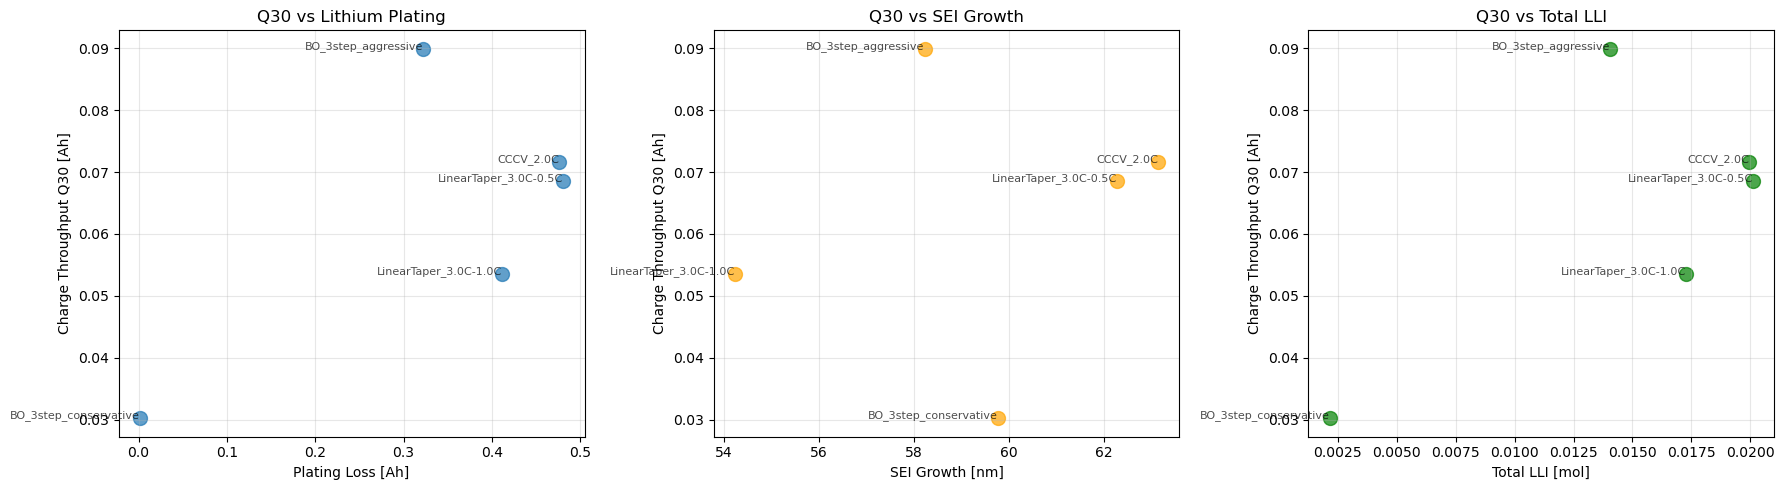


✓ Plots saved to results/baseline_tradeoffs.png


In [7]:
if len(df_success) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Q30 vs Plating
    axes[0].scatter(df_success['plating_loss'], df_success['Q30'], s=100, alpha=0.7)
    for _, row in df_success.iterrows():
        axes[0].annotate(row['name'], (row['plating_loss'], row['Q30']), 
                        fontsize=8, ha='right', alpha=0.7)
    axes[0].set_xlabel('Plating Loss [Ah]')
    axes[0].set_ylabel('Charge Throughput Q30 [Ah]')
    axes[0].set_title('Q30 vs Lithium Plating')
    axes[0].grid(True, alpha=0.3)
    
    # Q30 vs SEI
    axes[1].scatter(df_success['sei_growth'], df_success['Q30'], s=100, alpha=0.7, color='orange')
    for _, row in df_success.iterrows():
        axes[1].annotate(row['name'], (row['sei_growth'], row['Q30']), 
                        fontsize=8, ha='right', alpha=0.7)
    axes[1].set_xlabel('SEI Growth [nm]')
    axes[1].set_ylabel('Charge Throughput Q30 [Ah]')
    axes[1].set_title('Q30 vs SEI Growth')
    axes[1].grid(True, alpha=0.3)
    
    # Q30 vs Total LLI
    axes[2].scatter(df_success['total_lli'], df_success['Q30'], s=100, alpha=0.7, color='green')
    for _, row in df_success.iterrows():
        axes[2].annotate(row['name'], (row['total_lli'], row['Q30']), 
                        fontsize=8, ha='right', alpha=0.7)
    axes[2].set_xlabel('Total LLI [mol]')
    axes[2].set_ylabel('Charge Throughput Q30 [Ah]')
    axes[2].set_title('Q30 vs Total LLI')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/baseline_tradeoffs.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Plots saved to results/baseline_tradeoffs.png")
else:
    print("⚠ No data to plot")

## 8. Save Results

Export results for use in multi-objective optimization comparison:

In [ ]:
# Save to CSV
df.to_csv('results/baseline_results.csv', index=False)
print("✓ Results saved to results/baseline_results.csv")

# Save to JSON (preserves more structure)
import json
with open('results/baseline_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print("✓ Results saved to results/baseline_results.json")

# Print summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nTotal protocols evaluated: {len(df)}")
print(f"Successful simulations:    {df['success'].sum()}")
print(f"Failed simulations:        {(~df['success']).sum()}")

if len(df_success) > 0:
    print(f"\nQ30 range:          {df_success['Q30'].min():.6f} - {df_success['Q30'].max():.6f} Ah")
    print(f"Plating range:      {df_success['plating_loss'].min():.6f} - {df_success['plating_loss'].max():.6f} Ah")
    print(f"SEI growth range:   {df_success['sei_growth'].min():.2f} - {df_success['sei_growth'].max():.2f} nm")
    print(f"Total LLI range:    {df_success['total_lli'].min():.9f} - {df_success['total_lli'].max():.9f} mol")

print("\n" + "="*80)

---

## Conclusions

**Key Findings:**

1. **Trade-off between capacity and degradation**: No single protocol excels at all objectives
2. **Baseline performance envelope**: These results define the achievable region with standard approaches
3. **Multi-objective opportunity**: Room for improvement by finding Pareto-optimal protocols

**Next Steps:**

- Use these baselines as reference points for Pareto front comparison
- Proceed to multi-objective Bayesian optimization (Notebook 3)
- Goal: Find protocols that dominate these baselines across multiple objectives

---